<a href="https://colab.research.google.com/github/strongeryoung/Oracle_Bio_Service-development/blob/main/%EC%8B%A4%EC%8A%B53_GRU%EA%B8%B0%EB%B0%98_%EC%A3%BC%EC%8B%9D%EA%B0%80%EA%B2%A9_%EC%98%88%EC%B8%A1_0529.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import GRU, Dropout, Dense
from keras.models import Sequential

In [2]:
# 주식 심볼과 날짜 범위 지정
ticker_symbol = 'IBM'
start_date = '2000-01-01'
end_date = '2024-04-01'

# 주식 데이터 다운로드 및 종가(close) 가격만 사용
data = yf.download(ticker_symbol, start=start_date, end=end_date)
data_close = data[['Close']].values

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
# 데이터 정규화 (0~1 범위로 변환)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_close)

In [5]:
# 시계열 데이터를 입력과 출력으로 변환하는 함수 정의
def create_sequences(data, window_size):
  X, y = [], []
  for i in range(len(data) - window_size):
    X.append(data[i:(i + window_size)])
    y.append(data[i + window_size])
  return np.array(X), np.array(y)

window_size = 15
X, y = create_sequences(data_scaled, window_size)

In [6]:
# X, y의 첫 5개 샘플 출력
print("X 샘플 예시:", X[0])
print("y 샘플 예시:", y[0])

X 샘플 예시: [[0.18578512]
 [0.17361231]
 [0.18578512]
 [0.17960238]
 [0.17805628]
 [0.19196798]
 [0.19505961]
 [0.1966051 ]
 [0.19274081]
 [0.19699177]
 [0.18501218]
 [0.1966051 ]
 [0.19505961]
 [0.20278822]
 [0.20278822]]
y 샘플 예시: [0.19544584]


In [7]:
# 데이터를 학습 및 테스트 세트로 분할
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [8]:
## GRU 모델 구현 및 학습하기
# GRU 모델 구성
gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(window_size, 1)))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(50, return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(50))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
gru_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 15, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 15, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,601 (150.79 KB)

 Trainable params: 38,601 (150.79 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 모델 컴파일 및 학습
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(X_train, y_train, epochs=30, batch_size=24, verbose=1)

Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0093
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0012
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.7167e-04
Epoch 4/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.3941e-04
Epoch 5/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 7.4129e-04
Epoch 6/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.0884e-04
Epoch 7/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.4635e-04
Epoch 8/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.0446e-04
Epoch 9/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 5.9641e-04
Epoch 10/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.2649e-04
Epoch 11/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.2293e-04
Epoch 12/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.8020e-04
Epoch 13/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.1250e-04
Epoch 14/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4.2256e-04
Epoch

In [11]:
# 예측 수행
predicted_gru = gru_model.predict(X_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [12]:
# 예측값과 실제값을 원래 스케일로 역변환
predicted_gru = scaler.inverse_transform(predicted_gru)
y_test_actual = scaler.inverse_transform(y_test)

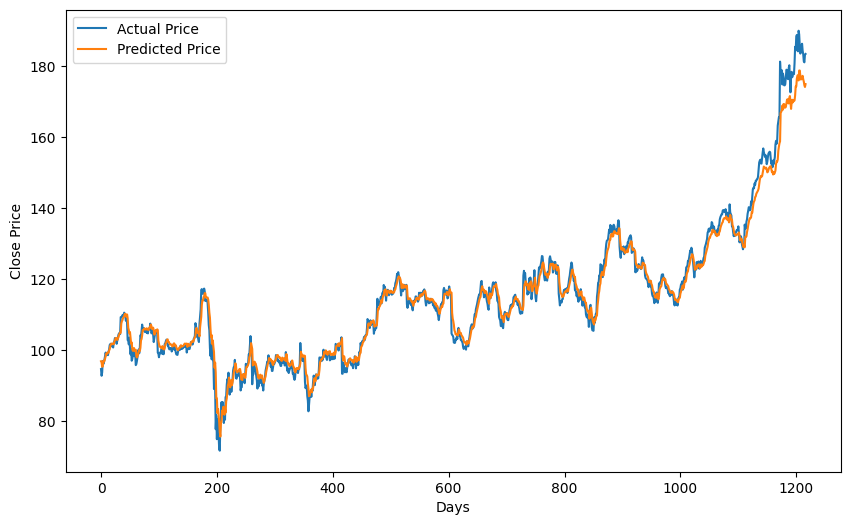

In [13]:
# 실제값과 예측 값 시각화
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predicted_gru, label='Predicted Price')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()